# Many-cell trajectory measurement


Designed to measure a series of time-dependent single-cell fluorescent/holographic intensities over the course of a time-lapse microscopy data set


```
Author: 
- Nathan J. Day (nathan.day.16@ucl.ac.uk)
```


### STEPS
1. Directory organisation
2. Load image information
3. Load the xyt data of each cell from HDF5 tracking file (see Arboretum tracker @quantumjot github)
4. Meta-analysis of tracks with optional filtering of anomalous tracks
5. Measure cellular properties across all images, all cells
6. Save information out as pandas df and .csv

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import ndimage
from skimage import io #used to be from skimage import io
from skimage.io import imshow
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
import btrack
from btrack.utils import import_HDF, import_JSON
from tqdm.notebook import tnrange, tqdm
from time import sleep
from pathlib import Path

## Measure 

Read cell mask information (location & area) and obtain fluorescent and phase stats. If the data already exists in a .csv and just needs to be plotted then skip to the plotter section.

#### Raw data (image) location

The image data needs to be organised inside the ```root_dir``` as follows:

```
phase/
    0000_phase.tif
    0001_phase.tif
    ...
gfp/
    0000_gfp.tif
    0001_gfp.tif
    ...
rfp/
    0000_rfp.tif
    0001_rfp.tif
    ...
labels/
    0000_mask.tif
    0001_mask.tif
    ...    
```

In [4]:
root_path = "/home/nathan/data/kraken/fucci/2017_10_18/pos16"
root_path = "/home/nathan/data/SHARC/fucci/fucci1_171201/"

gfp_dir = os.path.join(root_path, "gfp")
rfp_dir = os.path.join(root_path, "rfp")
phase_dir = os.path.join(root_path, "phase")
mask_dir = os.path.join(root_path, "labels")

gfp_list = natsorted([m for m in os.listdir(gfp_dir) if m.endswith('.tif')])
rfp_list = natsorted([m for m in os.listdir(rfp_dir) if m.endswith('.tif')])
phase_list = natsorted([m for m in os.listdir(phase_dir) if m.endswith('.tif')])
mask_list = natsorted([m for m in os.listdir(mask_dir) if m.endswith('.tif')])

### Load the tracking information to obtain xyt of cells

Load tracks directly from hdf5

In [5]:
filename ='/home/nathan/data/SHARC/fucci/fucci1_171201/tracks/tracks_cellpose/cellpose_nuclear.h5'
with btrack.dataio.HDF5FileHandler(filename, 'r') as h:
    tracks = h.tracks
tracks = (tracks[0]) #initially, tracks[0] is the tracks for cell type 0 (ie, WT or Scr etc)
print("Track information loaded")

[INFO][2020/08/12 06:29:34 PM] Opening HDF file: /home/nathan/data/SHARC/fucci/fucci1_171201/tracks/tracks_cellpose/cellpose_nuclear.h5
[INFO][2020/08/12 06:29:34 PM] Loading tracks: obj_type_1...
[INFO][2020/08/12 06:29:34 PM] Loading obj_type_1 (160396, 5) (160396 filtered: None)...
[INFO][2020/08/12 06:29:36 PM] Closing HDF file: /home/nathan/data/SHARC/fucci/fucci1_171201/tracks/tracks_cellpose/cellpose_nuclear.h5


Track information loaded


## Meta-analysis of tracks

List of track lengths

In [6]:
### length of tracks 
for i in range(len(tracks)):
    print("track ID.", tracks[i].ID,"length=", len(tracks[i]))

track ID. 65 length= 133
track ID. 77 length= 69
track ID. 76 length= 22
track ID. 75 length= 5
track ID. 74 length= 107
track ID. 73 length= 64
track ID. 72 length= 1091
track ID. 71 length= 2
track ID. 70 length= 386
track ID. 69 length= 55
track ID. 68 length= 349
track ID. 67 length= 23
track ID. 66 length= 75
track ID. 78 length= 178
track ID. 64 length= 629
track ID. 63 length= 52
track ID. 62 length= 57
track ID. 61 length= 96
track ID. 60 length= 21
track ID. 59 length= 7
track ID. 58 length= 94
track ID. 57 length= 865
track ID. 56 length= 86
track ID. 55 length= 25
track ID. 54 length= 602
track ID. 53 length= 37
track ID. 91 length= 160
track ID. 1 length= 12
track ID. 102 length= 1
track ID. 101 length= 558
track ID. 100 length= 23
track ID. 99 length= 128
track ID. 98 length= 12
track ID. 97 length= 111
track ID. 96 length= 25
track ID. 95 length= 58
track ID. 94 length= 609
track ID. 93 length= 49
track ID. 92 length= 59
track ID. 2 length= 591
track ID. 90 length= 22
tra

track ID. 1588 length= 339
track ID. 1589 length= 1
track ID. 1593 length= 3
track ID. 1592 length= 6
track ID. 1590 length= 338
track ID. 1591 length= 2
track ID. 1595 length= 2
track ID. 1594 length= 26
track ID. 1596 length= 1
track ID. 1597 length= 3
track ID. 1598 length= 3
track ID. 1599 length= 1
track ID. 1600 length= 1
track ID. 1601 length= 3
track ID. 1602 length= 16
track ID. 1603 length= 2
track ID. 1604 length= 18
track ID. 1605 length= 1
track ID. 1606 length= 4
track ID. 1607 length= 1
track ID. 1608 length= 1
track ID. 1610 length= 1
track ID. 1609 length= 1
track ID. 1611 length= 328
track ID. 1612 length= 1
track ID. 1613 length= 7
track ID. 1614 length= 1
track ID. 1615 length= 6
track ID. 1616 length= 1
track ID. 1617 length= 6
track ID. 1618 length= 52
track ID. 1619 length= 302
track ID. 1620 length= 1
track ID. 1622 length= 11
track ID. 1623 length= 1
track ID. 1625 length= 2
track ID. 1628 length= 1
track ID. 1627 length= 1
track ID. 1624 length= 11
track ID. 1

Histogram of track lengths

1092


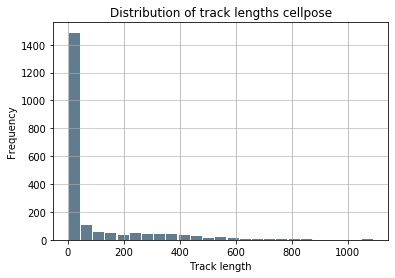

In [7]:
#size, scale = 1000, 10
track_lengths = [len(track) for track in tracks] 
tracks_df = pd.Series(track_lengths)
print(max(tracks_df))

tracks_df.plot.hist(grid=True, bins=25, rwidth=0.9,
                   color='#607c8e')
title = 'Distribution of track lengths cellpose'
plt.title(title)
plt.xlabel('Track length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

### Filter track lengths if desired

In [12]:
filtered_tracks = [track for track in tracks if len(track) > 1] #excludes track lengths below x frames
track_lengths = [len(track) for track in filtered_tracks] 
track_IDs = [track.ID for track in filtered_tracks] 
#track_IDs = natsorted(track_IDs)
print("number of tracks that are in this criterion are = ", len(track_IDs))
print(natsorted(track_IDs))
for i in range(len(track_lengths)):
    print("ID = ", track_IDs[i], "/ Length = ", track_lengths[i])

number of tracks that are in this criterion are =  1348
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 110, 111, 113, 114, 115, 117, 118, 123, 125, 126, 128, 129, 131, 132, 134, 135, 137, 143, 145, 146, 147, 148, 150, 152, 155, 158, 160, 161, 163, 164, 166, 167, 170, 172, 173, 174, 177, 178, 180, 181, 182, 185, 186, 189, 192, 196, 197, 198, 199, 201, 203, 205, 208, 211, 213, 214, 216, 218, 221, 222, 223, 224, 225, 226, 227, 229, 230, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254, 255, 257, 259, 260, 263, 264, 266, 267, 268, 269, 270, 272, 273, 274, 276, 282, 283, 285, 292, 293, 295, 296, 297, 29

# The _NUMBER CRUNCH_ zone

#### Data output directory creation 

In [32]:
mask_type = "cellpose_nuclear" # important to specify the origin of the masks so that results are printed correctly

In [33]:
### DIRECTORY CREATION ###
stats_dir = os.path.join(root_path, 'stats') 
mask_type_stats_dir = os.path.join(stats_dir, mask_type)     
    
Path(stats_dir).mkdir(parents=True, exist_ok=True)
Path(mask_type_stats_dir).mkdir(parents=True, exist_ok=True)   

## Calculations - this version measures summed fluoresence intensity over whole mask area

In [23]:
print('Total calculation progress bar below (n/N cells):')
for j, cell in enumerate(tqdm(filtered_tracks)):
    ID = str(filtered_tracks[j].ID)
    #ID = str(1100) #### if only 1 cell required
    print('cell ID = ',ID, 'progress bar below: (n/N frames):')## add to df
    frames = filtered_tracks[j].t
    x = filtered_tracks[j].x 
    y = filtered_tracks[j].y

    fn = "cell_ID_" + ID + ".csv"
    stat_file = os.path.normpath(os.path.join(mask_type_stats_dir, fn))

    df = pd.DataFrame([], columns=['Cell ID', 'Frame', 'GFP Intensity', 'RFP Intensity', 'Phase Intensity', 'Area', 'x','y', 'mask_fn']) #is this assignment of df correct? or does it overwrite "count_cells" above

    new_mask_list = [] #this creates a new mask list of only the necessary frames
    new_gfp_list = []
    new_rfp_list = []
    new_phase_list = []
    for k in frames:
        new_mask_list.append(mask_list[k]) 
        new_gfp_list.append(gfp_list[k])
        new_rfp_list.append(rfp_list[k])
        new_phase_list.append(phase_list[k])

    # below opens a mask image, uses xy coords to select specific mask, then uses that specific mask to measure other images
    for i, mask_name in enumerate(tqdm(new_mask_list)):
        #print(i, frames[i], mask_name, new_gfp_list[i], new_rfp_list[i], new_phase_list[i]) #sanity check to ensure correct images are being loaded+measured

        mask = io.imread(os.path.normpath(os.path.join(mask_dir, mask_name))) #load mask
        xi = int(x[i])
        yi = int(y[i]) #x and y coords
        labelled, n_labels = ndimage.label(mask) 
        
        #this block returns 0-value measurements if the cell_mask is unavailable at this frame, due to tracker-interpolation
        if (labelled[xi,yi] == 0):
            cell_mask = None
            area = None
            gfp_pix_value = None
            rfp_pix_value = None
            phase_pix_value = None
            
        else:
            cell_mask = labelled == labelled[xi,yi] #creating a new mask only including cell of interest
            area = ndimage.sum(cell_mask)

            #load images and measure
            gfp = io.imread(os.path.join(gfp_dir,new_gfp_list[i])) #load gfp image
            gfp_pix_value = ndimage.sum(gfp, cell_mask, 1) #measure cell_mask area of gfp image

            rfp = io.imread(os.path.join(rfp_dir,new_rfp_list[i]))
            rfp_pix_value = ndimage.sum(rfp, cell_mask, 1)

            phase = io.imread(os.path.join(phase_dir,new_phase_list[i]))
            phase_pix_value = ndimage.sum(phase, cell_mask, 1)

        #store measurements in pandas df
        df.loc[i, 'Cell ID'] = ID
        df.loc[i, 'Frame'] = frames[i]
        df.loc[i,'GFP Intensity'] = gfp_pix_value 
        df.loc[i,'RFP Intensity'] = rfp_pix_value
        df.loc[i,'Phase Intensity'] = phase_pix_value 
        df.loc[i,'Area'] = area
        df.loc[i, 'mask_fn'] = mask_name
        df.loc[i,'x'] = xi
        df.loc[i,'y'] = yi

    df.to_csv(stat_file, index=False)  
    #print(df)
print("FINISHHHHEEEEDDDDD")
os.system('spd-say "Master Nathan, your program has finished. I love you."')

Total calculation progress bar below (n/N cells):


cell ID =  688 progress bar below: (n/N frames):



cell ID =  1644 progress bar below: (n/N frames):



cell ID =  1646 progress bar below: (n/N frames):




FINISHHHHEEEEDDDDD


0

## Calculations

In [34]:
print('Total calculation progress bar below (n/N cells):')
for j, cell in enumerate(tqdm(filtered_tracks)):
    ID = str(filtered_tracks[j].ID)
    #ID = str(1100) #### if only 1 cell required
    print('cell ID = ',ID, 'progress bar below: (n/N frames):')## add to df
    frames = filtered_tracks[j].t
    x = filtered_tracks[j].x 
    y = filtered_tracks[j].y

    fn = "cell_ID_" + ID + ".csv"
    stat_file = os.path.normpath(os.path.join(mask_type_stats_dir, fn))

    df = pd.DataFrame([], columns=['Cell ID', 'Frame', 'GFP Intensity', 'RFP Intensity', 'Phase Intensity', 'Area', 'x','y', 'mask_fn']) #is this assignment of df correct? or does it overwrite "count_cells" above

    new_mask_list = [] #this creates a new mask list of only the necessary frames
    new_gfp_list = []
    new_rfp_list = []
    new_phase_list = []
    for k in frames:
        new_mask_list.append(mask_list[k]) 
        new_gfp_list.append(gfp_list[k])
        new_rfp_list.append(rfp_list[k])
        new_phase_list.append(phase_list[k])

    # below opens a mask image, uses xy coords to select specific mask, then uses that specific mask to measure other images
    for i, mask_name in enumerate(tqdm(new_mask_list)):
        #print(i, frames[i], mask_name, new_gfp_list[i], new_rfp_list[i], new_phase_list[i]) #sanity check to ensure correct images are being loaded+measured

        mask = io.imread(os.path.normpath(os.path.join(mask_dir, mask_name))) #load mask
        xi = int(x[i])
        yi = int(y[i]) #x and y coords
        labelled, n_labels = ndimage.label(mask) 
        
        #this block returns 0-value measurements if the cell_mask is unavailable at this frame, due to tracker-interpolation
        if (labelled[xi,yi] == 0):
            cell_mask = None
            area = None
            gfp_pix_value = None
            rfp_pix_value = None
            phase_pix_value = None
            
        else:
            cell_mask = labelled == labelled[xi,yi] #creating a new mask only including cell of interest
            area = ndimage.sum(cell_mask)

            #load images and measure
            gfp = io.imread(os.path.join(gfp_dir,new_gfp_list[i])) #load gfp image
            gfp_pix_value = ndimage.sum(gfp, cell_mask, 1) #measure cell_mask area of gfp image
            mean_gfp_value = gfp_pix_value / area
            rfp = io.imread(os.path.join(rfp_dir,new_rfp_list[i]))
            rfp_pix_value = ndimage.sum(rfp, cell_mask, 1)
            mean_rfp_value = rfp_pix_value / area
            phase = io.imread(os.path.join(phase_dir,new_phase_list[i]))
            phase_pix_value = ndimage.sum(phase, cell_mask, 1)
            mean_phase_value = phase_pix_value / area
        #store measurements in pandas df
        df.loc[i, 'Cell ID'] = ID
        df.loc[i, 'Frame'] = frames[i]
        df.loc[i,'GFP Intensity'] = gfp_pix_value 
        df.loc[i, 'Mean GFP Intensity'] = mean_gfp_value
        df.loc[i,'RFP Intensity'] = rfp_pix_value
        df.loc[i, 'Mean RFP Intensity'] = mean_rfp_value
        df.loc[i,'Phase Intensity'] = phase_pix_value 
        df.loc[i, 'Mean Phase Intensity'] = mean_phase_value
        df.loc[i,'Area'] = area
        df.loc[i, 'mask_fn'] = mask_name
        df.loc[i,'x'] = xi
        df.loc[i,'y'] = yi

    df.to_csv(stat_file, index=False)  
    #print(df)
print("FINISHHHHEEEEDDDDD")
os.system('spd-say "Master Nathan, your program has finished. I love you."')

Total calculation progress bar below (n/N cells):


cell ID =  65 progress bar below: (n/N frames):



cell ID =  77 progress bar below: (n/N frames):



cell ID =  76 progress bar below: (n/N frames):



cell ID =  75 progress bar below: (n/N frames):



cell ID =  74 progress bar below: (n/N frames):



cell ID =  73 progress bar below: (n/N frames):



cell ID =  72 progress bar below: (n/N frames):



cell ID =  71 progress bar below: (n/N frames):



cell ID =  70 progress bar below: (n/N frames):



cell ID =  69 progress bar below: (n/N frames):



cell ID =  68 progress bar below: (n/N frames):



cell ID =  67 progress bar below: (n/N frames):



cell ID =  66 progress bar below: (n/N frames):



cell ID =  78 progress bar below: (n/N frames):



cell ID =  64 progress bar below: (n/N frames):



cell ID =  63 progress bar below: (n/N frames):



cell ID =  62 progress bar below: (n/N frames):



cell ID =  61 progress bar below: (n/N frames):



cell ID =  60 progress bar below: (n/N frames):



cell ID =  59 progress bar below: (n/N frames):



cell ID =  58 progress bar below: (n/N frames):



cell ID =  57 progress bar below: (n/N frames):



cell ID =  56 progress bar below: (n/N frames):



cell ID =  55 progress bar below: (n/N frames):



cell ID =  54 progress bar below: (n/N frames):



cell ID =  53 progress bar below: (n/N frames):



cell ID =  91 progress bar below: (n/N frames):



cell ID =  1 progress bar below: (n/N frames):



cell ID =  101 progress bar below: (n/N frames):



cell ID =  100 progress bar below: (n/N frames):



cell ID =  99 progress bar below: (n/N frames):



cell ID =  98 progress bar below: (n/N frames):



cell ID =  97 progress bar below: (n/N frames):



cell ID =  96 progress bar below: (n/N frames):



cell ID =  95 progress bar below: (n/N frames):



cell ID =  94 progress bar below: (n/N frames):



cell ID =  93 progress bar below: (n/N frames):



cell ID =  92 progress bar below: (n/N frames):



cell ID =  2 progress bar below: (n/N frames):



cell ID =  90 progress bar below: (n/N frames):



cell ID =  89 progress bar below: (n/N frames):



cell ID =  88 progress bar below: (n/N frames):



cell ID =  87 progress bar below: (n/N frames):



cell ID =  86 progress bar below: (n/N frames):



cell ID =  85 progress bar below: (n/N frames):



cell ID =  84 progress bar below: (n/N frames):



cell ID =  83 progress bar below: (n/N frames):



cell ID =  82 progress bar below: (n/N frames):



cell ID =  81 progress bar below: (n/N frames):



cell ID =  80 progress bar below: (n/N frames):



cell ID =  79 progress bar below: (n/N frames):



cell ID =  26 progress bar below: (n/N frames):



cell ID =  25 progress bar below: (n/N frames):



cell ID =  23 progress bar below: (n/N frames):



cell ID =  22 progress bar below: (n/N frames):



cell ID =  21 progress bar below: (n/N frames):



cell ID =  20 progress bar below: (n/N frames):



cell ID =  19 progress bar below: (n/N frames):



cell ID =  18 progress bar below: (n/N frames):



cell ID =  17 progress bar below: (n/N frames):



cell ID =  16 progress bar below: (n/N frames):



cell ID =  15 progress bar below: (n/N frames):



cell ID =  51 progress bar below: (n/N frames):



cell ID =  13 progress bar below: (n/N frames):



cell ID =  12 progress bar below: (n/N frames):



cell ID =  11 progress bar below: (n/N frames):



cell ID =  10 progress bar below: (n/N frames):



cell ID =  9 progress bar below: (n/N frames):



cell ID =  8 progress bar below: (n/N frames):



cell ID =  7 progress bar below: (n/N frames):



cell ID =  6 progress bar below: (n/N frames):



cell ID =  5 progress bar below: (n/N frames):



cell ID =  4 progress bar below: (n/N frames):



cell ID =  3 progress bar below: (n/N frames):



cell ID =  52 progress bar below: (n/N frames):



cell ID =  28 progress bar below: (n/N frames):



cell ID =  50 progress bar below: (n/N frames):



cell ID =  49 progress bar below: (n/N frames):



cell ID =  48 progress bar below: (n/N frames):



cell ID =  47 progress bar below: (n/N frames):



cell ID =  46 progress bar below: (n/N frames):



cell ID =  45 progress bar below: (n/N frames):



cell ID =  44 progress bar below: (n/N frames):



cell ID =  43 progress bar below: (n/N frames):



cell ID =  42 progress bar below: (n/N frames):



cell ID =  41 progress bar below: (n/N frames):



cell ID =  38 progress bar below: (n/N frames):



cell ID =  27 progress bar below: (n/N frames):



cell ID =  30 progress bar below: (n/N frames):



cell ID =  31 progress bar below: (n/N frames):



cell ID =  32 progress bar below: (n/N frames):



cell ID =  33 progress bar below: (n/N frames):



cell ID =  34 progress bar below: (n/N frames):



cell ID =  35 progress bar below: (n/N frames):



cell ID =  36 progress bar below: (n/N frames):



cell ID =  37 progress bar below: (n/N frames):



cell ID =  39 progress bar below: (n/N frames):



cell ID =  104 progress bar below: (n/N frames):



cell ID =  111 progress bar below: (n/N frames):



cell ID =  110 progress bar below: (n/N frames):



cell ID =  106 progress bar below: (n/N frames):



cell ID =  105 progress bar below: (n/N frames):



cell ID =  113 progress bar below: (n/N frames):



cell ID =  114 progress bar below: (n/N frames):



cell ID =  115 progress bar below: (n/N frames):



cell ID =  117 progress bar below: (n/N frames):



cell ID =  118 progress bar below: (n/N frames):



cell ID =  123 progress bar below: (n/N frames):



cell ID =  125 progress bar below: (n/N frames):



cell ID =  126 progress bar below: (n/N frames):



cell ID =  132 progress bar below: (n/N frames):



cell ID =  131 progress bar below: (n/N frames):



cell ID =  129 progress bar below: (n/N frames):



cell ID =  128 progress bar below: (n/N frames):



cell ID =  134 progress bar below: (n/N frames):



cell ID =  135 progress bar below: (n/N frames):



cell ID =  137 progress bar below: (n/N frames):



cell ID =  143 progress bar below: (n/N frames):



cell ID =  145 progress bar below: (n/N frames):



cell ID =  146 progress bar below: (n/N frames):



cell ID =  147 progress bar below: (n/N frames):



cell ID =  148 progress bar below: (n/N frames):



cell ID =  150 progress bar below: (n/N frames):



cell ID =  152 progress bar below: (n/N frames):



cell ID =  155 progress bar below: (n/N frames):



cell ID =  158 progress bar below: (n/N frames):



cell ID =  160 progress bar below: (n/N frames):



cell ID =  161 progress bar below: (n/N frames):



cell ID =  163 progress bar below: (n/N frames):



cell ID =  164 progress bar below: (n/N frames):



cell ID =  166 progress bar below: (n/N frames):



cell ID =  167 progress bar below: (n/N frames):



cell ID =  170 progress bar below: (n/N frames):



cell ID =  172 progress bar below: (n/N frames):



cell ID =  173 progress bar below: (n/N frames):



cell ID =  174 progress bar below: (n/N frames):



cell ID =  177 progress bar below: (n/N frames):



cell ID =  178 progress bar below: (n/N frames):



cell ID =  180 progress bar below: (n/N frames):



cell ID =  181 progress bar below: (n/N frames):



cell ID =  182 progress bar below: (n/N frames):



cell ID =  186 progress bar below: (n/N frames):



cell ID =  185 progress bar below: (n/N frames):



cell ID =  189 progress bar below: (n/N frames):



cell ID =  192 progress bar below: (n/N frames):



cell ID =  198 progress bar below: (n/N frames):



cell ID =  197 progress bar below: (n/N frames):



cell ID =  196 progress bar below: (n/N frames):



cell ID =  199 progress bar below: (n/N frames):



cell ID =  201 progress bar below: (n/N frames):



cell ID =  203 progress bar below: (n/N frames):



cell ID =  205 progress bar below: (n/N frames):



cell ID =  208 progress bar below: (n/N frames):



cell ID =  211 progress bar below: (n/N frames):



cell ID =  213 progress bar below: (n/N frames):



cell ID =  214 progress bar below: (n/N frames):



cell ID =  216 progress bar below: (n/N frames):



cell ID =  218 progress bar below: (n/N frames):



cell ID =  221 progress bar below: (n/N frames):



cell ID =  222 progress bar below: (n/N frames):



cell ID =  223 progress bar below: (n/N frames):



cell ID =  227 progress bar below: (n/N frames):



cell ID =  225 progress bar below: (n/N frames):



cell ID =  226 progress bar below: (n/N frames):



cell ID =  224 progress bar below: (n/N frames):



cell ID =  229 progress bar below: (n/N frames):



cell ID =  230 progress bar below: (n/N frames):



cell ID =  234 progress bar below: (n/N frames):



cell ID =  235 progress bar below: (n/N frames):



cell ID =  236 progress bar below: (n/N frames):



cell ID =  237 progress bar below: (n/N frames):



cell ID =  238 progress bar below: (n/N frames):



cell ID =  239 progress bar below: (n/N frames):



cell ID =  241 progress bar below: (n/N frames):



cell ID =  242 progress bar below: (n/N frames):



cell ID =  240 progress bar below: (n/N frames):



cell ID =  244 progress bar below: (n/N frames):



cell ID =  245 progress bar below: (n/N frames):



cell ID =  246 progress bar below: (n/N frames):



cell ID =  247 progress bar below: (n/N frames):



cell ID =  248 progress bar below: (n/N frames):



cell ID =  249 progress bar below: (n/N frames):



cell ID =  250 progress bar below: (n/N frames):



cell ID =  254 progress bar below: (n/N frames):



cell ID =  253 progress bar below: (n/N frames):



cell ID =  251 progress bar below: (n/N frames):



cell ID =  255 progress bar below: (n/N frames):



cell ID =  257 progress bar below: (n/N frames):



cell ID =  259 progress bar below: (n/N frames):



cell ID =  260 progress bar below: (n/N frames):



cell ID =  263 progress bar below: (n/N frames):



cell ID =  264 progress bar below: (n/N frames):



cell ID =  266 progress bar below: (n/N frames):



cell ID =  270 progress bar below: (n/N frames):



cell ID =  274 progress bar below: (n/N frames):



cell ID =  273 progress bar below: (n/N frames):



cell ID =  272 progress bar below: (n/N frames):



cell ID =  269 progress bar below: (n/N frames):



cell ID =  268 progress bar below: (n/N frames):



cell ID =  267 progress bar below: (n/N frames):



cell ID =  276 progress bar below: (n/N frames):



cell ID =  282 progress bar below: (n/N frames):



cell ID =  283 progress bar below: (n/N frames):



cell ID =  285 progress bar below: (n/N frames):



cell ID =  292 progress bar below: (n/N frames):



cell ID =  293 progress bar below: (n/N frames):



cell ID =  295 progress bar below: (n/N frames):



cell ID =  296 progress bar below: (n/N frames):



cell ID =  298 progress bar below: (n/N frames):



cell ID =  297 progress bar below: (n/N frames):



cell ID =  301 progress bar below: (n/N frames):



cell ID =  303 progress bar below: (n/N frames):



cell ID =  304 progress bar below: (n/N frames):



cell ID =  308 progress bar below: (n/N frames):



cell ID =  309 progress bar below: (n/N frames):



cell ID =  307 progress bar below: (n/N frames):



cell ID =  306 progress bar below: (n/N frames):



cell ID =  316 progress bar below: (n/N frames):



cell ID =  318 progress bar below: (n/N frames):



cell ID =  317 progress bar below: (n/N frames):



cell ID =  315 progress bar below: (n/N frames):



cell ID =  314 progress bar below: (n/N frames):



cell ID =  313 progress bar below: (n/N frames):



cell ID =  312 progress bar below: (n/N frames):



cell ID =  310 progress bar below: (n/N frames):



cell ID =  322 progress bar below: (n/N frames):



cell ID =  325 progress bar below: (n/N frames):



cell ID =  327 progress bar below: (n/N frames):



cell ID =  326 progress bar below: (n/N frames):



cell ID =  324 progress bar below: (n/N frames):



cell ID =  330 progress bar below: (n/N frames):



cell ID =  331 progress bar below: (n/N frames):



cell ID =  332 progress bar below: (n/N frames):



cell ID =  333 progress bar below: (n/N frames):



cell ID =  337 progress bar below: (n/N frames):



cell ID =  339 progress bar below: (n/N frames):



cell ID =  340 progress bar below: (n/N frames):



cell ID =  343 progress bar below: (n/N frames):



cell ID =  345 progress bar below: (n/N frames):



cell ID =  346 progress bar below: (n/N frames):



cell ID =  348 progress bar below: (n/N frames):



cell ID =  350 progress bar below: (n/N frames):



cell ID =  351 progress bar below: (n/N frames):



cell ID =  356 progress bar below: (n/N frames):



cell ID =  357 progress bar below: (n/N frames):



cell ID =  360 progress bar below: (n/N frames):



cell ID =  359 progress bar below: (n/N frames):



cell ID =  358 progress bar below: (n/N frames):



cell ID =  361 progress bar below: (n/N frames):



cell ID =  362 progress bar below: (n/N frames):



cell ID =  363 progress bar below: (n/N frames):



cell ID =  364 progress bar below: (n/N frames):



cell ID =  365 progress bar below: (n/N frames):



cell ID =  366 progress bar below: (n/N frames):



cell ID =  367 progress bar below: (n/N frames):



cell ID =  368 progress bar below: (n/N frames):



cell ID =  369 progress bar below: (n/N frames):



cell ID =  370 progress bar below: (n/N frames):



cell ID =  374 progress bar below: (n/N frames):



cell ID =  375 progress bar below: (n/N frames):



cell ID =  376 progress bar below: (n/N frames):



cell ID =  377 progress bar below: (n/N frames):



cell ID =  378 progress bar below: (n/N frames):



cell ID =  382 progress bar below: (n/N frames):



cell ID =  381 progress bar below: (n/N frames):



cell ID =  383 progress bar below: (n/N frames):



cell ID =  385 progress bar below: (n/N frames):



cell ID =  386 progress bar below: (n/N frames):



cell ID =  387 progress bar below: (n/N frames):



cell ID =  388 progress bar below: (n/N frames):



cell ID =  389 progress bar below: (n/N frames):



cell ID =  391 progress bar below: (n/N frames):



cell ID =  394 progress bar below: (n/N frames):



cell ID =  395 progress bar below: (n/N frames):



cell ID =  398 progress bar below: (n/N frames):



cell ID =  399 progress bar below: (n/N frames):



cell ID =  400 progress bar below: (n/N frames):



cell ID =  402 progress bar below: (n/N frames):



cell ID =  406 progress bar below: (n/N frames):



cell ID =  407 progress bar below: (n/N frames):



cell ID =  408 progress bar below: (n/N frames):



cell ID =  411 progress bar below: (n/N frames):



cell ID =  413 progress bar below: (n/N frames):



cell ID =  416 progress bar below: (n/N frames):



cell ID =  415 progress bar below: (n/N frames):



cell ID =  414 progress bar below: (n/N frames):



cell ID =  417 progress bar below: (n/N frames):



cell ID =  418 progress bar below: (n/N frames):



cell ID =  420 progress bar below: (n/N frames):



cell ID =  421 progress bar below: (n/N frames):



cell ID =  422 progress bar below: (n/N frames):



cell ID =  424 progress bar below: (n/N frames):



cell ID =  428 progress bar below: (n/N frames):



cell ID =  429 progress bar below: (n/N frames):



cell ID =  434 progress bar below: (n/N frames):



cell ID =  435 progress bar below: (n/N frames):



cell ID =  430 progress bar below: (n/N frames):



cell ID =  432 progress bar below: (n/N frames):



cell ID =  433 progress bar below: (n/N frames):



cell ID =  431 progress bar below: (n/N frames):



cell ID =  437 progress bar below: (n/N frames):



cell ID =  438 progress bar below: (n/N frames):



cell ID =  439 progress bar below: (n/N frames):



cell ID =  440 progress bar below: (n/N frames):



cell ID =  441 progress bar below: (n/N frames):



cell ID =  442 progress bar below: (n/N frames):



cell ID =  444 progress bar below: (n/N frames):



cell ID =  445 progress bar below: (n/N frames):



cell ID =  446 progress bar below: (n/N frames):



cell ID =  447 progress bar below: (n/N frames):



cell ID =  448 progress bar below: (n/N frames):



cell ID =  449 progress bar below: (n/N frames):



cell ID =  451 progress bar below: (n/N frames):



cell ID =  456 progress bar below: (n/N frames):



cell ID =  457 progress bar below: (n/N frames):



cell ID =  458 progress bar below: (n/N frames):



cell ID =  459 progress bar below: (n/N frames):



cell ID =  460 progress bar below: (n/N frames):



cell ID =  461 progress bar below: (n/N frames):



cell ID =  462 progress bar below: (n/N frames):



cell ID =  464 progress bar below: (n/N frames):



cell ID =  465 progress bar below: (n/N frames):



cell ID =  466 progress bar below: (n/N frames):



cell ID =  468 progress bar below: (n/N frames):



cell ID =  469 progress bar below: (n/N frames):



cell ID =  470 progress bar below: (n/N frames):



cell ID =  471 progress bar below: (n/N frames):



cell ID =  472 progress bar below: (n/N frames):



cell ID =  473 progress bar below: (n/N frames):



cell ID =  475 progress bar below: (n/N frames):



cell ID =  477 progress bar below: (n/N frames):



cell ID =  478 progress bar below: (n/N frames):



cell ID =  480 progress bar below: (n/N frames):



cell ID =  482 progress bar below: (n/N frames):



cell ID =  483 progress bar below: (n/N frames):



cell ID =  484 progress bar below: (n/N frames):



cell ID =  485 progress bar below: (n/N frames):



cell ID =  486 progress bar below: (n/N frames):



cell ID =  487 progress bar below: (n/N frames):



cell ID =  488 progress bar below: (n/N frames):



cell ID =  489 progress bar below: (n/N frames):



cell ID =  490 progress bar below: (n/N frames):



cell ID =  494 progress bar below: (n/N frames):



cell ID =  495 progress bar below: (n/N frames):



cell ID =  496 progress bar below: (n/N frames):



cell ID =  500 progress bar below: (n/N frames):



cell ID =  499 progress bar below: (n/N frames):



cell ID =  498 progress bar below: (n/N frames):



cell ID =  503 progress bar below: (n/N frames):



cell ID =  504 progress bar below: (n/N frames):



cell ID =  505 progress bar below: (n/N frames):



cell ID =  507 progress bar below: (n/N frames):



cell ID =  508 progress bar below: (n/N frames):



cell ID =  509 progress bar below: (n/N frames):



cell ID =  510 progress bar below: (n/N frames):



cell ID =  511 progress bar below: (n/N frames):



cell ID =  512 progress bar below: (n/N frames):



cell ID =  513 progress bar below: (n/N frames):



cell ID =  514 progress bar below: (n/N frames):



cell ID =  517 progress bar below: (n/N frames):



cell ID =  518 progress bar below: (n/N frames):



cell ID =  516 progress bar below: (n/N frames):



cell ID =  515 progress bar below: (n/N frames):



cell ID =  519 progress bar below: (n/N frames):



cell ID =  520 progress bar below: (n/N frames):



cell ID =  521 progress bar below: (n/N frames):



cell ID =  522 progress bar below: (n/N frames):



cell ID =  524 progress bar below: (n/N frames):



cell ID =  525 progress bar below: (n/N frames):



cell ID =  526 progress bar below: (n/N frames):



cell ID =  528 progress bar below: (n/N frames):



cell ID =  529 progress bar below: (n/N frames):



cell ID =  533 progress bar below: (n/N frames):



cell ID =  534 progress bar below: (n/N frames):



cell ID =  539 progress bar below: (n/N frames):



cell ID =  540 progress bar below: (n/N frames):



cell ID =  541 progress bar below: (n/N frames):



cell ID =  542 progress bar below: (n/N frames):



cell ID =  543 progress bar below: (n/N frames):



cell ID =  544 progress bar below: (n/N frames):



cell ID =  545 progress bar below: (n/N frames):



cell ID =  547 progress bar below: (n/N frames):



cell ID =  552 progress bar below: (n/N frames):



cell ID =  554 progress bar below: (n/N frames):



cell ID =  553 progress bar below: (n/N frames):



cell ID =  556 progress bar below: (n/N frames):



cell ID =  557 progress bar below: (n/N frames):



cell ID =  558 progress bar below: (n/N frames):



cell ID =  559 progress bar below: (n/N frames):



cell ID =  562 progress bar below: (n/N frames):



cell ID =  564 progress bar below: (n/N frames):



cell ID =  565 progress bar below: (n/N frames):



cell ID =  566 progress bar below: (n/N frames):



cell ID =  567 progress bar below: (n/N frames):



cell ID =  568 progress bar below: (n/N frames):



cell ID =  573 progress bar below: (n/N frames):



cell ID =  571 progress bar below: (n/N frames):



cell ID =  570 progress bar below: (n/N frames):



cell ID =  574 progress bar below: (n/N frames):



cell ID =  576 progress bar below: (n/N frames):



cell ID =  575 progress bar below: (n/N frames):



cell ID =  577 progress bar below: (n/N frames):



cell ID =  579 progress bar below: (n/N frames):



cell ID =  580 progress bar below: (n/N frames):



cell ID =  581 progress bar below: (n/N frames):



cell ID =  582 progress bar below: (n/N frames):



cell ID =  583 progress bar below: (n/N frames):



cell ID =  584 progress bar below: (n/N frames):



cell ID =  589 progress bar below: (n/N frames):



cell ID =  590 progress bar below: (n/N frames):



cell ID =  591 progress bar below: (n/N frames):



cell ID =  593 progress bar below: (n/N frames):



cell ID =  594 progress bar below: (n/N frames):



cell ID =  595 progress bar below: (n/N frames):



cell ID =  597 progress bar below: (n/N frames):



cell ID =  598 progress bar below: (n/N frames):



cell ID =  599 progress bar below: (n/N frames):



cell ID =  600 progress bar below: (n/N frames):



cell ID =  601 progress bar below: (n/N frames):



cell ID =  604 progress bar below: (n/N frames):



cell ID =  605 progress bar below: (n/N frames):



cell ID =  606 progress bar below: (n/N frames):



cell ID =  608 progress bar below: (n/N frames):



cell ID =  610 progress bar below: (n/N frames):



cell ID =  615 progress bar below: (n/N frames):



cell ID =  614 progress bar below: (n/N frames):



cell ID =  621 progress bar below: (n/N frames):



cell ID =  622 progress bar below: (n/N frames):



cell ID =  624 progress bar below: (n/N frames):



cell ID =  626 progress bar below: (n/N frames):



cell ID =  633 progress bar below: (n/N frames):



cell ID =  632 progress bar below: (n/N frames):



cell ID =  631 progress bar below: (n/N frames):



cell ID =  628 progress bar below: (n/N frames):



cell ID =  627 progress bar below: (n/N frames):



cell ID =  635 progress bar below: (n/N frames):



cell ID =  636 progress bar below: (n/N frames):



cell ID =  637 progress bar below: (n/N frames):



cell ID =  640 progress bar below: (n/N frames):



cell ID =  644 progress bar below: (n/N frames):



cell ID =  646 progress bar below: (n/N frames):



cell ID =  647 progress bar below: (n/N frames):



cell ID =  648 progress bar below: (n/N frames):



cell ID =  649 progress bar below: (n/N frames):



cell ID =  651 progress bar below: (n/N frames):



cell ID =  653 progress bar below: (n/N frames):



cell ID =  652 progress bar below: (n/N frames):



cell ID =  654 progress bar below: (n/N frames):



cell ID =  656 progress bar below: (n/N frames):



cell ID =  658 progress bar below: (n/N frames):



cell ID =  659 progress bar below: (n/N frames):



cell ID =  661 progress bar below: (n/N frames):



cell ID =  662 progress bar below: (n/N frames):



cell ID =  666 progress bar below: (n/N frames):



cell ID =  664 progress bar below: (n/N frames):



cell ID =  667 progress bar below: (n/N frames):



cell ID =  668 progress bar below: (n/N frames):



cell ID =  669 progress bar below: (n/N frames):



cell ID =  672 progress bar below: (n/N frames):



cell ID =  673 progress bar below: (n/N frames):



cell ID =  675 progress bar below: (n/N frames):



cell ID =  677 progress bar below: (n/N frames):



cell ID =  679 progress bar below: (n/N frames):



cell ID =  682 progress bar below: (n/N frames):



cell ID =  680 progress bar below: (n/N frames):



cell ID =  683 progress bar below: (n/N frames):



cell ID =  684 progress bar below: (n/N frames):



cell ID =  685 progress bar below: (n/N frames):



cell ID =  686 progress bar below: (n/N frames):



cell ID =  688 progress bar below: (n/N frames):



cell ID =  689 progress bar below: (n/N frames):



cell ID =  690 progress bar below: (n/N frames):



cell ID =  691 progress bar below: (n/N frames):



cell ID =  694 progress bar below: (n/N frames):



cell ID =  695 progress bar below: (n/N frames):



cell ID =  698 progress bar below: (n/N frames):



cell ID =  701 progress bar below: (n/N frames):



cell ID =  704 progress bar below: (n/N frames):



cell ID =  705 progress bar below: (n/N frames):



cell ID =  706 progress bar below: (n/N frames):



cell ID =  708 progress bar below: (n/N frames):



cell ID =  709 progress bar below: (n/N frames):



cell ID =  722 progress bar below: (n/N frames):



cell ID =  720 progress bar below: (n/N frames):



cell ID =  719 progress bar below: (n/N frames):



cell ID =  714 progress bar below: (n/N frames):



cell ID =  718 progress bar below: (n/N frames):



cell ID =  717 progress bar below: (n/N frames):



cell ID =  716 progress bar below: (n/N frames):



cell ID =  711 progress bar below: (n/N frames):



cell ID =  713 progress bar below: (n/N frames):



cell ID =  712 progress bar below: (n/N frames):



cell ID =  723 progress bar below: (n/N frames):



cell ID =  724 progress bar below: (n/N frames):



cell ID =  725 progress bar below: (n/N frames):



cell ID =  727 progress bar below: (n/N frames):



cell ID =  735 progress bar below: (n/N frames):



cell ID =  739 progress bar below: (n/N frames):



cell ID =  744 progress bar below: (n/N frames):



cell ID =  742 progress bar below: (n/N frames):



cell ID =  740 progress bar below: (n/N frames):



cell ID =  737 progress bar below: (n/N frames):



cell ID =  748 progress bar below: (n/N frames):



cell ID =  749 progress bar below: (n/N frames):



cell ID =  750 progress bar below: (n/N frames):



cell ID =  751 progress bar below: (n/N frames):



cell ID =  752 progress bar below: (n/N frames):



cell ID =  753 progress bar below: (n/N frames):



cell ID =  754 progress bar below: (n/N frames):



cell ID =  756 progress bar below: (n/N frames):



cell ID =  757 progress bar below: (n/N frames):



cell ID =  759 progress bar below: (n/N frames):



cell ID =  760 progress bar below: (n/N frames):



cell ID =  761 progress bar below: (n/N frames):



cell ID =  763 progress bar below: (n/N frames):



cell ID =  764 progress bar below: (n/N frames):



cell ID =  770 progress bar below: (n/N frames):



cell ID =  771 progress bar below: (n/N frames):



cell ID =  775 progress bar below: (n/N frames):



cell ID =  776 progress bar below: (n/N frames):



cell ID =  783 progress bar below: (n/N frames):



cell ID =  785 progress bar below: (n/N frames):



cell ID =  786 progress bar below: (n/N frames):



cell ID =  787 progress bar below: (n/N frames):



cell ID =  788 progress bar below: (n/N frames):



cell ID =  789 progress bar below: (n/N frames):



cell ID =  790 progress bar below: (n/N frames):



cell ID =  792 progress bar below: (n/N frames):



cell ID =  794 progress bar below: (n/N frames):



cell ID =  795 progress bar below: (n/N frames):



cell ID =  800 progress bar below: (n/N frames):



cell ID =  801 progress bar below: (n/N frames):



cell ID =  802 progress bar below: (n/N frames):



cell ID =  803 progress bar below: (n/N frames):



cell ID =  804 progress bar below: (n/N frames):



cell ID =  805 progress bar below: (n/N frames):



cell ID =  807 progress bar below: (n/N frames):



cell ID =  809 progress bar below: (n/N frames):



cell ID =  810 progress bar below: (n/N frames):



cell ID =  811 progress bar below: (n/N frames):



cell ID =  812 progress bar below: (n/N frames):



cell ID =  813 progress bar below: (n/N frames):



cell ID =  814 progress bar below: (n/N frames):



cell ID =  815 progress bar below: (n/N frames):



cell ID =  816 progress bar below: (n/N frames):



cell ID =  817 progress bar below: (n/N frames):



cell ID =  819 progress bar below: (n/N frames):



cell ID =  820 progress bar below: (n/N frames):



cell ID =  821 progress bar below: (n/N frames):



cell ID =  822 progress bar below: (n/N frames):



cell ID =  823 progress bar below: (n/N frames):



cell ID =  829 progress bar below: (n/N frames):



cell ID =  830 progress bar below: (n/N frames):



cell ID =  833 progress bar below: (n/N frames):



cell ID =  835 progress bar below: (n/N frames):



cell ID =  838 progress bar below: (n/N frames):



cell ID =  839 progress bar below: (n/N frames):



cell ID =  841 progress bar below: (n/N frames):



cell ID =  840 progress bar below: (n/N frames):



cell ID =  847 progress bar below: (n/N frames):



cell ID =  849 progress bar below: (n/N frames):



cell ID =  850 progress bar below: (n/N frames):



cell ID =  851 progress bar below: (n/N frames):



cell ID =  852 progress bar below: (n/N frames):



cell ID =  853 progress bar below: (n/N frames):



cell ID =  855 progress bar below: (n/N frames):



cell ID =  856 progress bar below: (n/N frames):



cell ID =  860 progress bar below: (n/N frames):



cell ID =  859 progress bar below: (n/N frames):



cell ID =  857 progress bar below: (n/N frames):



cell ID =  863 progress bar below: (n/N frames):



cell ID =  864 progress bar below: (n/N frames):



cell ID =  865 progress bar below: (n/N frames):



cell ID =  866 progress bar below: (n/N frames):



cell ID =  871 progress bar below: (n/N frames):



cell ID =  872 progress bar below: (n/N frames):



cell ID =  873 progress bar below: (n/N frames):



cell ID =  876 progress bar below: (n/N frames):



cell ID =  878 progress bar below: (n/N frames):



cell ID =  882 progress bar below: (n/N frames):



cell ID =  885 progress bar below: (n/N frames):



cell ID =  886 progress bar below: (n/N frames):



cell ID =  887 progress bar below: (n/N frames):



cell ID =  888 progress bar below: (n/N frames):



cell ID =  889 progress bar below: (n/N frames):



cell ID =  890 progress bar below: (n/N frames):



cell ID =  891 progress bar below: (n/N frames):



cell ID =  892 progress bar below: (n/N frames):



cell ID =  893 progress bar below: (n/N frames):



cell ID =  894 progress bar below: (n/N frames):



cell ID =  896 progress bar below: (n/N frames):



cell ID =  899 progress bar below: (n/N frames):



cell ID =  898 progress bar below: (n/N frames):



cell ID =  902 progress bar below: (n/N frames):



cell ID =  903 progress bar below: (n/N frames):



cell ID =  904 progress bar below: (n/N frames):



cell ID =  905 progress bar below: (n/N frames):



cell ID =  907 progress bar below: (n/N frames):



cell ID =  910 progress bar below: (n/N frames):



cell ID =  909 progress bar below: (n/N frames):



cell ID =  913 progress bar below: (n/N frames):



cell ID =  914 progress bar below: (n/N frames):



cell ID =  915 progress bar below: (n/N frames):



cell ID =  917 progress bar below: (n/N frames):



cell ID =  916 progress bar below: (n/N frames):



cell ID =  918 progress bar below: (n/N frames):



cell ID =  924 progress bar below: (n/N frames):



cell ID =  927 progress bar below: (n/N frames):



cell ID =  928 progress bar below: (n/N frames):



cell ID =  931 progress bar below: (n/N frames):



cell ID =  934 progress bar below: (n/N frames):



cell ID =  937 progress bar below: (n/N frames):



cell ID =  940 progress bar below: (n/N frames):



cell ID =  944 progress bar below: (n/N frames):



cell ID =  942 progress bar below: (n/N frames):



cell ID =  945 progress bar below: (n/N frames):



cell ID =  946 progress bar below: (n/N frames):



cell ID =  947 progress bar below: (n/N frames):



cell ID =  948 progress bar below: (n/N frames):



cell ID =  949 progress bar below: (n/N frames):



cell ID =  950 progress bar below: (n/N frames):



cell ID =  955 progress bar below: (n/N frames):



cell ID =  954 progress bar below: (n/N frames):



cell ID =  952 progress bar below: (n/N frames):



cell ID =  958 progress bar below: (n/N frames):



cell ID =  959 progress bar below: (n/N frames):



cell ID =  963 progress bar below: (n/N frames):



cell ID =  964 progress bar below: (n/N frames):



cell ID =  965 progress bar below: (n/N frames):



cell ID =  966 progress bar below: (n/N frames):



cell ID =  970 progress bar below: (n/N frames):



cell ID =  971 progress bar below: (n/N frames):



cell ID =  973 progress bar below: (n/N frames):



cell ID =  974 progress bar below: (n/N frames):



cell ID =  975 progress bar below: (n/N frames):



cell ID =  978 progress bar below: (n/N frames):



cell ID =  980 progress bar below: (n/N frames):



cell ID =  981 progress bar below: (n/N frames):



cell ID =  984 progress bar below: (n/N frames):



cell ID =  983 progress bar below: (n/N frames):



cell ID =  986 progress bar below: (n/N frames):



cell ID =  987 progress bar below: (n/N frames):



cell ID =  988 progress bar below: (n/N frames):



cell ID =  989 progress bar below: (n/N frames):



cell ID =  990 progress bar below: (n/N frames):



cell ID =  991 progress bar below: (n/N frames):



cell ID =  993 progress bar below: (n/N frames):



cell ID =  994 progress bar below: (n/N frames):



cell ID =  1000 progress bar below: (n/N frames):



cell ID =  1004 progress bar below: (n/N frames):



cell ID =  1005 progress bar below: (n/N frames):



cell ID =  1006 progress bar below: (n/N frames):



cell ID =  1007 progress bar below: (n/N frames):



cell ID =  1012 progress bar below: (n/N frames):



cell ID =  1014 progress bar below: (n/N frames):



cell ID =  1018 progress bar below: (n/N frames):



cell ID =  1024 progress bar below: (n/N frames):



cell ID =  1025 progress bar below: (n/N frames):



cell ID =  1027 progress bar below: (n/N frames):



cell ID =  1032 progress bar below: (n/N frames):



cell ID =  1038 progress bar below: (n/N frames):



cell ID =  1039 progress bar below: (n/N frames):



cell ID =  1040 progress bar below: (n/N frames):



cell ID =  1043 progress bar below: (n/N frames):



cell ID =  1045 progress bar below: (n/N frames):



cell ID =  1047 progress bar below: (n/N frames):



cell ID =  1051 progress bar below: (n/N frames):



cell ID =  1052 progress bar below: (n/N frames):



cell ID =  1056 progress bar below: (n/N frames):



cell ID =  1065 progress bar below: (n/N frames):



cell ID =  1066 progress bar below: (n/N frames):



cell ID =  1069 progress bar below: (n/N frames):



cell ID =  1070 progress bar below: (n/N frames):



cell ID =  1072 progress bar below: (n/N frames):



cell ID =  1075 progress bar below: (n/N frames):



cell ID =  1076 progress bar below: (n/N frames):



cell ID =  1079 progress bar below: (n/N frames):



cell ID =  1080 progress bar below: (n/N frames):



cell ID =  1081 progress bar below: (n/N frames):



cell ID =  1082 progress bar below: (n/N frames):



cell ID =  1083 progress bar below: (n/N frames):



cell ID =  1084 progress bar below: (n/N frames):



cell ID =  1085 progress bar below: (n/N frames):



cell ID =  1086 progress bar below: (n/N frames):



cell ID =  1088 progress bar below: (n/N frames):



cell ID =  1089 progress bar below: (n/N frames):



cell ID =  1092 progress bar below: (n/N frames):



cell ID =  1093 progress bar below: (n/N frames):



cell ID =  1094 progress bar below: (n/N frames):



cell ID =  1097 progress bar below: (n/N frames):



cell ID =  1095 progress bar below: (n/N frames):



cell ID =  1098 progress bar below: (n/N frames):



cell ID =  1099 progress bar below: (n/N frames):



cell ID =  1100 progress bar below: (n/N frames):



cell ID =  1101 progress bar below: (n/N frames):



cell ID =  1102 progress bar below: (n/N frames):



cell ID =  1103 progress bar below: (n/N frames):



cell ID =  1104 progress bar below: (n/N frames):



cell ID =  1114 progress bar below: (n/N frames):



cell ID =  1115 progress bar below: (n/N frames):



cell ID =  1122 progress bar below: (n/N frames):



cell ID =  1124 progress bar below: (n/N frames):



cell ID =  1125 progress bar below: (n/N frames):



cell ID =  1126 progress bar below: (n/N frames):



cell ID =  1132 progress bar below: (n/N frames):



cell ID =  1133 progress bar below: (n/N frames):



cell ID =  1135 progress bar below: (n/N frames):



cell ID =  1140 progress bar below: (n/N frames):



cell ID =  1141 progress bar below: (n/N frames):



cell ID =  1147 progress bar below: (n/N frames):



cell ID =  1150 progress bar below: (n/N frames):



cell ID =  1151 progress bar below: (n/N frames):



cell ID =  1153 progress bar below: (n/N frames):



cell ID =  1154 progress bar below: (n/N frames):



cell ID =  1158 progress bar below: (n/N frames):



cell ID =  1159 progress bar below: (n/N frames):



cell ID =  1155 progress bar below: (n/N frames):



cell ID =  1157 progress bar below: (n/N frames):



cell ID =  1162 progress bar below: (n/N frames):



cell ID =  1165 progress bar below: (n/N frames):



cell ID =  1168 progress bar below: (n/N frames):



cell ID =  1169 progress bar below: (n/N frames):



cell ID =  1170 progress bar below: (n/N frames):



cell ID =  1172 progress bar below: (n/N frames):



cell ID =  1173 progress bar below: (n/N frames):



cell ID =  1174 progress bar below: (n/N frames):



cell ID =  1175 progress bar below: (n/N frames):



cell ID =  1177 progress bar below: (n/N frames):



cell ID =  1183 progress bar below: (n/N frames):



cell ID =  1185 progress bar below: (n/N frames):



cell ID =  1186 progress bar below: (n/N frames):



cell ID =  1187 progress bar below: (n/N frames):



cell ID =  1190 progress bar below: (n/N frames):



cell ID =  1191 progress bar below: (n/N frames):



cell ID =  1192 progress bar below: (n/N frames):



cell ID =  1193 progress bar below: (n/N frames):



cell ID =  1196 progress bar below: (n/N frames):



cell ID =  1197 progress bar below: (n/N frames):



cell ID =  1202 progress bar below: (n/N frames):



cell ID =  1206 progress bar below: (n/N frames):



cell ID =  1207 progress bar below: (n/N frames):



cell ID =  1208 progress bar below: (n/N frames):



cell ID =  1209 progress bar below: (n/N frames):



cell ID =  1213 progress bar below: (n/N frames):



cell ID =  1214 progress bar below: (n/N frames):



cell ID =  1215 progress bar below: (n/N frames):



cell ID =  1218 progress bar below: (n/N frames):



cell ID =  1219 progress bar below: (n/N frames):



cell ID =  1220 progress bar below: (n/N frames):



cell ID =  1224 progress bar below: (n/N frames):



cell ID =  1230 progress bar below: (n/N frames):



cell ID =  1231 progress bar below: (n/N frames):



cell ID =  1232 progress bar below: (n/N frames):



cell ID =  1233 progress bar below: (n/N frames):



cell ID =  1234 progress bar below: (n/N frames):



cell ID =  1235 progress bar below: (n/N frames):



cell ID =  1236 progress bar below: (n/N frames):



cell ID =  1238 progress bar below: (n/N frames):



cell ID =  1240 progress bar below: (n/N frames):



cell ID =  1241 progress bar below: (n/N frames):



cell ID =  1243 progress bar below: (n/N frames):



cell ID =  1244 progress bar below: (n/N frames):



cell ID =  1254 progress bar below: (n/N frames):



cell ID =  1256 progress bar below: (n/N frames):



cell ID =  1257 progress bar below: (n/N frames):



cell ID =  1258 progress bar below: (n/N frames):



cell ID =  1263 progress bar below: (n/N frames):



cell ID =  1261 progress bar below: (n/N frames):



cell ID =  1267 progress bar below: (n/N frames):



cell ID =  1268 progress bar below: (n/N frames):



cell ID =  1270 progress bar below: (n/N frames):



cell ID =  1271 progress bar below: (n/N frames):



cell ID =  1275 progress bar below: (n/N frames):



cell ID =  1279 progress bar below: (n/N frames):



cell ID =  1283 progress bar below: (n/N frames):



cell ID =  1284 progress bar below: (n/N frames):



cell ID =  1281 progress bar below: (n/N frames):



cell ID =  1280 progress bar below: (n/N frames):



cell ID =  1282 progress bar below: (n/N frames):



cell ID =  1285 progress bar below: (n/N frames):



cell ID =  1286 progress bar below: (n/N frames):



cell ID =  1287 progress bar below: (n/N frames):



cell ID =  1288 progress bar below: (n/N frames):



cell ID =  1289 progress bar below: (n/N frames):



cell ID =  1292 progress bar below: (n/N frames):



cell ID =  1294 progress bar below: (n/N frames):



cell ID =  1300 progress bar below: (n/N frames):



cell ID =  1298 progress bar below: (n/N frames):



cell ID =  1296 progress bar below: (n/N frames):



cell ID =  1295 progress bar below: (n/N frames):



cell ID =  1302 progress bar below: (n/N frames):



cell ID =  1303 progress bar below: (n/N frames):



cell ID =  1305 progress bar below: (n/N frames):



cell ID =  1306 progress bar below: (n/N frames):



cell ID =  1307 progress bar below: (n/N frames):



cell ID =  1308 progress bar below: (n/N frames):



cell ID =  1309 progress bar below: (n/N frames):



cell ID =  1310 progress bar below: (n/N frames):



cell ID =  1311 progress bar below: (n/N frames):



cell ID =  1314 progress bar below: (n/N frames):



cell ID =  1317 progress bar below: (n/N frames):



cell ID =  1316 progress bar below: (n/N frames):



cell ID =  1315 progress bar below: (n/N frames):



cell ID =  1319 progress bar below: (n/N frames):



cell ID =  1321 progress bar below: (n/N frames):



cell ID =  1322 progress bar below: (n/N frames):



cell ID =  1323 progress bar below: (n/N frames):



cell ID =  1325 progress bar below: (n/N frames):



cell ID =  1326 progress bar below: (n/N frames):



cell ID =  1328 progress bar below: (n/N frames):



cell ID =  1329 progress bar below: (n/N frames):



cell ID =  1330 progress bar below: (n/N frames):



cell ID =  1331 progress bar below: (n/N frames):



cell ID =  1334 progress bar below: (n/N frames):



cell ID =  1336 progress bar below: (n/N frames):



cell ID =  1335 progress bar below: (n/N frames):



cell ID =  1337 progress bar below: (n/N frames):



cell ID =  1340 progress bar below: (n/N frames):



cell ID =  1341 progress bar below: (n/N frames):



cell ID =  1346 progress bar below: (n/N frames):



cell ID =  1347 progress bar below: (n/N frames):



cell ID =  1348 progress bar below: (n/N frames):



cell ID =  1349 progress bar below: (n/N frames):



cell ID =  1351 progress bar below: (n/N frames):



cell ID =  1352 progress bar below: (n/N frames):



cell ID =  1350 progress bar below: (n/N frames):



cell ID =  1355 progress bar below: (n/N frames):



cell ID =  1358 progress bar below: (n/N frames):



cell ID =  1362 progress bar below: (n/N frames):



cell ID =  1363 progress bar below: (n/N frames):



cell ID =  1364 progress bar below: (n/N frames):



cell ID =  1365 progress bar below: (n/N frames):



cell ID =  1368 progress bar below: (n/N frames):



cell ID =  1369 progress bar below: (n/N frames):



cell ID =  1371 progress bar below: (n/N frames):



cell ID =  1372 progress bar below: (n/N frames):



cell ID =  1374 progress bar below: (n/N frames):



cell ID =  1375 progress bar below: (n/N frames):



cell ID =  1377 progress bar below: (n/N frames):



cell ID =  1378 progress bar below: (n/N frames):



cell ID =  1379 progress bar below: (n/N frames):



cell ID =  1383 progress bar below: (n/N frames):



cell ID =  1387 progress bar below: (n/N frames):



cell ID =  1389 progress bar below: (n/N frames):



cell ID =  1390 progress bar below: (n/N frames):



cell ID =  1391 progress bar below: (n/N frames):



cell ID =  1392 progress bar below: (n/N frames):



cell ID =  1393 progress bar below: (n/N frames):



cell ID =  1394 progress bar below: (n/N frames):



cell ID =  1395 progress bar below: (n/N frames):



cell ID =  1397 progress bar below: (n/N frames):



cell ID =  1398 progress bar below: (n/N frames):



cell ID =  1401 progress bar below: (n/N frames):



cell ID =  1404 progress bar below: (n/N frames):



cell ID =  1408 progress bar below: (n/N frames):



cell ID =  1409 progress bar below: (n/N frames):



cell ID =  1410 progress bar below: (n/N frames):



cell ID =  1411 progress bar below: (n/N frames):



cell ID =  1412 progress bar below: (n/N frames):



cell ID =  1416 progress bar below: (n/N frames):



cell ID =  1417 progress bar below: (n/N frames):



cell ID =  1420 progress bar below: (n/N frames):



cell ID =  1421 progress bar below: (n/N frames):



cell ID =  1422 progress bar below: (n/N frames):



cell ID =  1423 progress bar below: (n/N frames):



cell ID =  1424 progress bar below: (n/N frames):



cell ID =  1425 progress bar below: (n/N frames):



cell ID =  1426 progress bar below: (n/N frames):



cell ID =  1427 progress bar below: (n/N frames):



cell ID =  1429 progress bar below: (n/N frames):



cell ID =  1430 progress bar below: (n/N frames):



cell ID =  1431 progress bar below: (n/N frames):



cell ID =  1432 progress bar below: (n/N frames):



cell ID =  1434 progress bar below: (n/N frames):



cell ID =  1437 progress bar below: (n/N frames):



cell ID =  1436 progress bar below: (n/N frames):



cell ID =  1435 progress bar below: (n/N frames):



cell ID =  1444 progress bar below: (n/N frames):



cell ID =  1445 progress bar below: (n/N frames):



cell ID =  1446 progress bar below: (n/N frames):



cell ID =  1447 progress bar below: (n/N frames):



cell ID =  1449 progress bar below: (n/N frames):



cell ID =  1450 progress bar below: (n/N frames):



cell ID =  1451 progress bar below: (n/N frames):



cell ID =  1454 progress bar below: (n/N frames):



cell ID =  1452 progress bar below: (n/N frames):



cell ID =  1453 progress bar below: (n/N frames):



cell ID =  1459 progress bar below: (n/N frames):



cell ID =  1464 progress bar below: (n/N frames):



cell ID =  1463 progress bar below: (n/N frames):



cell ID =  1462 progress bar below: (n/N frames):



cell ID =  1466 progress bar below: (n/N frames):



cell ID =  1468 progress bar below: (n/N frames):



cell ID =  1470 progress bar below: (n/N frames):



cell ID =  1469 progress bar below: (n/N frames):



cell ID =  1472 progress bar below: (n/N frames):



cell ID =  1473 progress bar below: (n/N frames):



cell ID =  1475 progress bar below: (n/N frames):



cell ID =  1481 progress bar below: (n/N frames):



cell ID =  1479 progress bar below: (n/N frames):



cell ID =  1482 progress bar below: (n/N frames):



cell ID =  1483 progress bar below: (n/N frames):



cell ID =  1484 progress bar below: (n/N frames):



cell ID =  1490 progress bar below: (n/N frames):



cell ID =  1494 progress bar below: (n/N frames):



cell ID =  1496 progress bar below: (n/N frames):



cell ID =  1495 progress bar below: (n/N frames):



cell ID =  1497 progress bar below: (n/N frames):



cell ID =  1498 progress bar below: (n/N frames):



cell ID =  1500 progress bar below: (n/N frames):



cell ID =  1501 progress bar below: (n/N frames):



cell ID =  1504 progress bar below: (n/N frames):



cell ID =  1505 progress bar below: (n/N frames):



cell ID =  1506 progress bar below: (n/N frames):



cell ID =  1509 progress bar below: (n/N frames):



cell ID =  1512 progress bar below: (n/N frames):



cell ID =  1515 progress bar below: (n/N frames):



cell ID =  1517 progress bar below: (n/N frames):



cell ID =  1522 progress bar below: (n/N frames):



cell ID =  1527 progress bar below: (n/N frames):



cell ID =  1528 progress bar below: (n/N frames):



cell ID =  1531 progress bar below: (n/N frames):



cell ID =  1532 progress bar below: (n/N frames):



cell ID =  1533 progress bar below: (n/N frames):



cell ID =  1534 progress bar below: (n/N frames):



cell ID =  1536 progress bar below: (n/N frames):



cell ID =  1541 progress bar below: (n/N frames):



cell ID =  1542 progress bar below: (n/N frames):



cell ID =  1544 progress bar below: (n/N frames):



cell ID =  1545 progress bar below: (n/N frames):



cell ID =  1546 progress bar below: (n/N frames):



cell ID =  1548 progress bar below: (n/N frames):



cell ID =  1556 progress bar below: (n/N frames):



cell ID =  1557 progress bar below: (n/N frames):



cell ID =  1558 progress bar below: (n/N frames):



cell ID =  1560 progress bar below: (n/N frames):



cell ID =  1562 progress bar below: (n/N frames):



cell ID =  1570 progress bar below: (n/N frames):



cell ID =  1569 progress bar below: (n/N frames):



cell ID =  1568 progress bar below: (n/N frames):



cell ID =  1564 progress bar below: (n/N frames):



cell ID =  1561 progress bar below: (n/N frames):



cell ID =  1566 progress bar below: (n/N frames):



cell ID =  1572 progress bar below: (n/N frames):



cell ID =  1573 progress bar below: (n/N frames):



cell ID =  1574 progress bar below: (n/N frames):



cell ID =  1579 progress bar below: (n/N frames):



cell ID =  1583 progress bar below: (n/N frames):



cell ID =  1587 progress bar below: (n/N frames):



cell ID =  1588 progress bar below: (n/N frames):



cell ID =  1593 progress bar below: (n/N frames):



cell ID =  1592 progress bar below: (n/N frames):



cell ID =  1590 progress bar below: (n/N frames):



cell ID =  1591 progress bar below: (n/N frames):



cell ID =  1595 progress bar below: (n/N frames):



cell ID =  1594 progress bar below: (n/N frames):



cell ID =  1597 progress bar below: (n/N frames):



cell ID =  1598 progress bar below: (n/N frames):



cell ID =  1601 progress bar below: (n/N frames):



cell ID =  1602 progress bar below: (n/N frames):



cell ID =  1603 progress bar below: (n/N frames):



cell ID =  1604 progress bar below: (n/N frames):



cell ID =  1606 progress bar below: (n/N frames):



cell ID =  1611 progress bar below: (n/N frames):



cell ID =  1613 progress bar below: (n/N frames):



cell ID =  1615 progress bar below: (n/N frames):



cell ID =  1617 progress bar below: (n/N frames):



cell ID =  1618 progress bar below: (n/N frames):



cell ID =  1619 progress bar below: (n/N frames):



cell ID =  1622 progress bar below: (n/N frames):



cell ID =  1625 progress bar below: (n/N frames):



cell ID =  1624 progress bar below: (n/N frames):



cell ID =  1630 progress bar below: (n/N frames):



cell ID =  1631 progress bar below: (n/N frames):



cell ID =  1632 progress bar below: (n/N frames):



cell ID =  1635 progress bar below: (n/N frames):



cell ID =  1638 progress bar below: (n/N frames):



cell ID =  1639 progress bar below: (n/N frames):



cell ID =  1640 progress bar below: (n/N frames):



cell ID =  1641 progress bar below: (n/N frames):



cell ID =  1644 progress bar below: (n/N frames):



cell ID =  1646 progress bar below: (n/N frames):



cell ID =  1647 progress bar below: (n/N frames):



cell ID =  1651 progress bar below: (n/N frames):



cell ID =  1652 progress bar below: (n/N frames):



cell ID =  1653 progress bar below: (n/N frames):



cell ID =  1654 progress bar below: (n/N frames):



cell ID =  1659 progress bar below: (n/N frames):



cell ID =  1656 progress bar below: (n/N frames):



cell ID =  1655 progress bar below: (n/N frames):



cell ID =  1657 progress bar below: (n/N frames):



cell ID =  1662 progress bar below: (n/N frames):



cell ID =  1664 progress bar below: (n/N frames):



cell ID =  1665 progress bar below: (n/N frames):



cell ID =  1666 progress bar below: (n/N frames):



cell ID =  1667 progress bar below: (n/N frames):



cell ID =  1668 progress bar below: (n/N frames):



cell ID =  1673 progress bar below: (n/N frames):



cell ID =  1672 progress bar below: (n/N frames):



cell ID =  1675 progress bar below: (n/N frames):



cell ID =  1676 progress bar below: (n/N frames):



cell ID =  1681 progress bar below: (n/N frames):



cell ID =  1684 progress bar below: (n/N frames):



cell ID =  1685 progress bar below: (n/N frames):



cell ID =  1686 progress bar below: (n/N frames):



cell ID =  1687 progress bar below: (n/N frames):



cell ID =  1694 progress bar below: (n/N frames):



cell ID =  1691 progress bar below: (n/N frames):



cell ID =  1692 progress bar below: (n/N frames):



cell ID =  1697 progress bar below: (n/N frames):



cell ID =  1698 progress bar below: (n/N frames):



cell ID =  1699 progress bar below: (n/N frames):



cell ID =  1702 progress bar below: (n/N frames):



cell ID =  1703 progress bar below: (n/N frames):



cell ID =  1705 progress bar below: (n/N frames):



cell ID =  1706 progress bar below: (n/N frames):



cell ID =  1707 progress bar below: (n/N frames):



cell ID =  1708 progress bar below: (n/N frames):



cell ID =  1709 progress bar below: (n/N frames):



cell ID =  1712 progress bar below: (n/N frames):



cell ID =  1715 progress bar below: (n/N frames):



cell ID =  1717 progress bar below: (n/N frames):



cell ID =  1718 progress bar below: (n/N frames):



cell ID =  1721 progress bar below: (n/N frames):



cell ID =  1724 progress bar below: (n/N frames):



cell ID =  1725 progress bar below: (n/N frames):



cell ID =  1726 progress bar below: (n/N frames):



cell ID =  1736 progress bar below: (n/N frames):



cell ID =  1733 progress bar below: (n/N frames):



cell ID =  1731 progress bar below: (n/N frames):



cell ID =  1727 progress bar below: (n/N frames):



cell ID =  1728 progress bar below: (n/N frames):



cell ID =  1738 progress bar below: (n/N frames):



cell ID =  1739 progress bar below: (n/N frames):



cell ID =  1737 progress bar below: (n/N frames):



cell ID =  1741 progress bar below: (n/N frames):



cell ID =  1748 progress bar below: (n/N frames):



cell ID =  1745 progress bar below: (n/N frames):



cell ID =  1749 progress bar below: (n/N frames):



cell ID =  1752 progress bar below: (n/N frames):



cell ID =  1756 progress bar below: (n/N frames):



cell ID =  1757 progress bar below: (n/N frames):



cell ID =  1761 progress bar below: (n/N frames):



cell ID =  1760 progress bar below: (n/N frames):



cell ID =  1762 progress bar below: (n/N frames):



cell ID =  1765 progress bar below: (n/N frames):



cell ID =  1766 progress bar below: (n/N frames):



cell ID =  1767 progress bar below: (n/N frames):



cell ID =  1769 progress bar below: (n/N frames):



cell ID =  1770 progress bar below: (n/N frames):



cell ID =  1772 progress bar below: (n/N frames):



cell ID =  1773 progress bar below: (n/N frames):



cell ID =  1777 progress bar below: (n/N frames):



cell ID =  1778 progress bar below: (n/N frames):



cell ID =  1779 progress bar below: (n/N frames):



cell ID =  1780 progress bar below: (n/N frames):



cell ID =  1781 progress bar below: (n/N frames):



cell ID =  1784 progress bar below: (n/N frames):



cell ID =  1785 progress bar below: (n/N frames):



cell ID =  1786 progress bar below: (n/N frames):



cell ID =  1787 progress bar below: (n/N frames):



cell ID =  1788 progress bar below: (n/N frames):



cell ID =  1789 progress bar below: (n/N frames):



cell ID =  1790 progress bar below: (n/N frames):



cell ID =  1793 progress bar below: (n/N frames):



cell ID =  1792 progress bar below: (n/N frames):



cell ID =  1791 progress bar below: (n/N frames):



cell ID =  1795 progress bar below: (n/N frames):



cell ID =  1796 progress bar below: (n/N frames):



cell ID =  1799 progress bar below: (n/N frames):



cell ID =  1800 progress bar below: (n/N frames):



cell ID =  1801 progress bar below: (n/N frames):



cell ID =  1802 progress bar below: (n/N frames):



cell ID =  1804 progress bar below: (n/N frames):



cell ID =  1805 progress bar below: (n/N frames):



cell ID =  1810 progress bar below: (n/N frames):



cell ID =  1813 progress bar below: (n/N frames):



cell ID =  1811 progress bar below: (n/N frames):



cell ID =  1809 progress bar below: (n/N frames):



cell ID =  1808 progress bar below: (n/N frames):



cell ID =  1806 progress bar below: (n/N frames):



cell ID =  1815 progress bar below: (n/N frames):



cell ID =  1817 progress bar below: (n/N frames):



cell ID =  1818 progress bar below: (n/N frames):



cell ID =  1821 progress bar below: (n/N frames):



cell ID =  1822 progress bar below: (n/N frames):



cell ID =  1824 progress bar below: (n/N frames):



cell ID =  1825 progress bar below: (n/N frames):



cell ID =  1826 progress bar below: (n/N frames):



cell ID =  1828 progress bar below: (n/N frames):



cell ID =  1831 progress bar below: (n/N frames):



cell ID =  1833 progress bar below: (n/N frames):



cell ID =  1832 progress bar below: (n/N frames):



cell ID =  1829 progress bar below: (n/N frames):



cell ID =  1834 progress bar below: (n/N frames):



cell ID =  1835 progress bar below: (n/N frames):



cell ID =  1836 progress bar below: (n/N frames):



cell ID =  1839 progress bar below: (n/N frames):



cell ID =  1842 progress bar below: (n/N frames):



cell ID =  1844 progress bar below: (n/N frames):



cell ID =  1845 progress bar below: (n/N frames):



cell ID =  1847 progress bar below: (n/N frames):



cell ID =  1848 progress bar below: (n/N frames):



cell ID =  1852 progress bar below: (n/N frames):



cell ID =  1854 progress bar below: (n/N frames):



cell ID =  1856 progress bar below: (n/N frames):



cell ID =  1860 progress bar below: (n/N frames):



cell ID =  1862 progress bar below: (n/N frames):



cell ID =  1863 progress bar below: (n/N frames):



cell ID =  1864 progress bar below: (n/N frames):



cell ID =  1871 progress bar below: (n/N frames):



cell ID =  1869 progress bar below: (n/N frames):



cell ID =  1872 progress bar below: (n/N frames):



cell ID =  1873 progress bar below: (n/N frames):



cell ID =  1874 progress bar below: (n/N frames):



cell ID =  1875 progress bar below: (n/N frames):



cell ID =  1876 progress bar below: (n/N frames):



cell ID =  1878 progress bar below: (n/N frames):



cell ID =  1880 progress bar below: (n/N frames):



cell ID =  1883 progress bar below: (n/N frames):



cell ID =  1889 progress bar below: (n/N frames):



cell ID =  1891 progress bar below: (n/N frames):



cell ID =  1893 progress bar below: (n/N frames):



cell ID =  1894 progress bar below: (n/N frames):



cell ID =  1896 progress bar below: (n/N frames):



cell ID =  1897 progress bar below: (n/N frames):



cell ID =  1903 progress bar below: (n/N frames):



cell ID =  1900 progress bar below: (n/N frames):



cell ID =  1898 progress bar below: (n/N frames):



cell ID =  1902 progress bar below: (n/N frames):



cell ID =  1909 progress bar below: (n/N frames):



cell ID =  1911 progress bar below: (n/N frames):



cell ID =  1913 progress bar below: (n/N frames):



cell ID =  1914 progress bar below: (n/N frames):



cell ID =  1915 progress bar below: (n/N frames):



cell ID =  1921 progress bar below: (n/N frames):



cell ID =  1920 progress bar below: (n/N frames):



cell ID =  1919 progress bar below: (n/N frames):



cell ID =  1917 progress bar below: (n/N frames):



cell ID =  1916 progress bar below: (n/N frames):



cell ID =  1924 progress bar below: (n/N frames):



cell ID =  1928 progress bar below: (n/N frames):



cell ID =  1929 progress bar below: (n/N frames):



cell ID =  1932 progress bar below: (n/N frames):



cell ID =  1934 progress bar below: (n/N frames):



cell ID =  1936 progress bar below: (n/N frames):



cell ID =  1938 progress bar below: (n/N frames):



cell ID =  1939 progress bar below: (n/N frames):



cell ID =  1941 progress bar below: (n/N frames):



cell ID =  1942 progress bar below: (n/N frames):



cell ID =  1944 progress bar below: (n/N frames):



cell ID =  1945 progress bar below: (n/N frames):



cell ID =  1946 progress bar below: (n/N frames):



cell ID =  1947 progress bar below: (n/N frames):



cell ID =  1949 progress bar below: (n/N frames):



cell ID =  1950 progress bar below: (n/N frames):



cell ID =  1951 progress bar below: (n/N frames):



cell ID =  1952 progress bar below: (n/N frames):



cell ID =  1956 progress bar below: (n/N frames):



cell ID =  1955 progress bar below: (n/N frames):



cell ID =  1953 progress bar below: (n/N frames):



cell ID =  1954 progress bar below: (n/N frames):



cell ID =  1958 progress bar below: (n/N frames):



cell ID =  1960 progress bar below: (n/N frames):



cell ID =  1961 progress bar below: (n/N frames):



cell ID =  1962 progress bar below: (n/N frames):



cell ID =  1963 progress bar below: (n/N frames):



cell ID =  1964 progress bar below: (n/N frames):



cell ID =  1965 progress bar below: (n/N frames):



cell ID =  1973 progress bar below: (n/N frames):



cell ID =  1972 progress bar below: (n/N frames):



cell ID =  1974 progress bar below: (n/N frames):



cell ID =  1977 progress bar below: (n/N frames):



cell ID =  1982 progress bar below: (n/N frames):



cell ID =  1984 progress bar below: (n/N frames):



cell ID =  1985 progress bar below: (n/N frames):



cell ID =  1987 progress bar below: (n/N frames):



cell ID =  1989 progress bar below: (n/N frames):



cell ID =  1990 progress bar below: (n/N frames):



cell ID =  1994 progress bar below: (n/N frames):



cell ID =  1991 progress bar below: (n/N frames):



cell ID =  1992 progress bar below: (n/N frames):



cell ID =  1993 progress bar below: (n/N frames):



cell ID =  1996 progress bar below: (n/N frames):



cell ID =  1998 progress bar below: (n/N frames):



cell ID =  1999 progress bar below: (n/N frames):



cell ID =  2000 progress bar below: (n/N frames):



cell ID =  2001 progress bar below: (n/N frames):



cell ID =  2002 progress bar below: (n/N frames):



cell ID =  2003 progress bar below: (n/N frames):



cell ID =  2004 progress bar below: (n/N frames):



cell ID =  2008 progress bar below: (n/N frames):



cell ID =  2009 progress bar below: (n/N frames):



cell ID =  2010 progress bar below: (n/N frames):



cell ID =  2014 progress bar below: (n/N frames):



cell ID =  2015 progress bar below: (n/N frames):



cell ID =  2018 progress bar below: (n/N frames):



cell ID =  2020 progress bar below: (n/N frames):



cell ID =  2023 progress bar below: (n/N frames):



cell ID =  2024 progress bar below: (n/N frames):



cell ID =  2026 progress bar below: (n/N frames):



cell ID =  2027 progress bar below: (n/N frames):



cell ID =  2029 progress bar below: (n/N frames):



cell ID =  2034 progress bar below: (n/N frames):



cell ID =  2037 progress bar below: (n/N frames):



cell ID =  2039 progress bar below: (n/N frames):



cell ID =  2044 progress bar below: (n/N frames):



cell ID =  2046 progress bar below: (n/N frames):



cell ID =  2048 progress bar below: (n/N frames):



cell ID =  2049 progress bar below: (n/N frames):



cell ID =  2050 progress bar below: (n/N frames):



cell ID =  2051 progress bar below: (n/N frames):



cell ID =  2052 progress bar below: (n/N frames):



cell ID =  2053 progress bar below: (n/N frames):



cell ID =  2054 progress bar below: (n/N frames):



cell ID =  2055 progress bar below: (n/N frames):



cell ID =  2056 progress bar below: (n/N frames):



cell ID =  2058 progress bar below: (n/N frames):



cell ID =  2059 progress bar below: (n/N frames):



cell ID =  2063 progress bar below: (n/N frames):



cell ID =  2064 progress bar below: (n/N frames):



cell ID =  2068 progress bar below: (n/N frames):



cell ID =  2071 progress bar below: (n/N frames):



cell ID =  2072 progress bar below: (n/N frames):



cell ID =  2073 progress bar below: (n/N frames):



cell ID =  2075 progress bar below: (n/N frames):



cell ID =  2076 progress bar below: (n/N frames):



cell ID =  2080 progress bar below: (n/N frames):



cell ID =  2085 progress bar below: (n/N frames):



cell ID =  2086 progress bar below: (n/N frames):



cell ID =  2087 progress bar below: (n/N frames):



cell ID =  2089 progress bar below: (n/N frames):



cell ID =  2093 progress bar below: (n/N frames):



cell ID =  2099 progress bar below: (n/N frames):



cell ID =  2105 progress bar below: (n/N frames):



cell ID =  2109 progress bar below: (n/N frames):



cell ID =  2112 progress bar below: (n/N frames):



cell ID =  2113 progress bar below: (n/N frames):



cell ID =  2114 progress bar below: (n/N frames):



cell ID =  2115 progress bar below: (n/N frames):



cell ID =  2119 progress bar below: (n/N frames):



cell ID =  2124 progress bar below: (n/N frames):



cell ID =  2125 progress bar below: (n/N frames):



cell ID =  2123 progress bar below: (n/N frames):



cell ID =  2122 progress bar below: (n/N frames):



cell ID =  2121 progress bar below: (n/N frames):



cell ID =  2120 progress bar below: (n/N frames):



cell ID =  2126 progress bar below: (n/N frames):



cell ID =  2129 progress bar below: (n/N frames):



cell ID =  2130 progress bar below: (n/N frames):



cell ID =  2131 progress bar below: (n/N frames):



cell ID =  2133 progress bar below: (n/N frames):



cell ID =  2136 progress bar below: (n/N frames):



cell ID =  2137 progress bar below: (n/N frames):



cell ID =  2140 progress bar below: (n/N frames):



cell ID =  2146 progress bar below: (n/N frames):



cell ID =  2147 progress bar below: (n/N frames):



cell ID =  2149 progress bar below: (n/N frames):



cell ID =  2151 progress bar below: (n/N frames):



cell ID =  2153 progress bar below: (n/N frames):



cell ID =  2155 progress bar below: (n/N frames):



cell ID =  2156 progress bar below: (n/N frames):



cell ID =  2158 progress bar below: (n/N frames):



cell ID =  2157 progress bar below: (n/N frames):



cell ID =  2162 progress bar below: (n/N frames):



cell ID =  2165 progress bar below: (n/N frames):



cell ID =  2167 progress bar below: (n/N frames):



cell ID =  2171 progress bar below: (n/N frames):



cell ID =  2170 progress bar below: (n/N frames):



cell ID =  2169 progress bar below: (n/N frames):



cell ID =  2174 progress bar below: (n/N frames):



cell ID =  2175 progress bar below: (n/N frames):



cell ID =  2182 progress bar below: (n/N frames):



cell ID =  2183 progress bar below: (n/N frames):



cell ID =  2187 progress bar below: (n/N frames):



cell ID =  2190 progress bar below: (n/N frames):



cell ID =  2193 progress bar below: (n/N frames):



cell ID =  2194 progress bar below: (n/N frames):



cell ID =  2195 progress bar below: (n/N frames):



cell ID =  2197 progress bar below: (n/N frames):



cell ID =  2198 progress bar below: (n/N frames):



cell ID =  2201 progress bar below: (n/N frames):



cell ID =  2205 progress bar below: (n/N frames):



cell ID =  2207 progress bar below: (n/N frames):



cell ID =  2208 progress bar below: (n/N frames):



cell ID =  2209 progress bar below: (n/N frames):



cell ID =  2210 progress bar below: (n/N frames):



cell ID =  2213 progress bar below: (n/N frames):



cell ID =  2212 progress bar below: (n/N frames):



cell ID =  2214 progress bar below: (n/N frames):



cell ID =  2217 progress bar below: (n/N frames):



cell ID =  2219 progress bar below: (n/N frames):



cell ID =  2220 progress bar below: (n/N frames):



cell ID =  2225 progress bar below: (n/N frames):



cell ID =  2226 progress bar below: (n/N frames):



cell ID =  2227 progress bar below: (n/N frames):



cell ID =  2229 progress bar below: (n/N frames):



cell ID =  2230 progress bar below: (n/N frames):



cell ID =  2235 progress bar below: (n/N frames):



cell ID =  2236 progress bar below: (n/N frames):



cell ID =  2239 progress bar below: (n/N frames):



cell ID =  2241 progress bar below: (n/N frames):



cell ID =  2243 progress bar below: (n/N frames):



cell ID =  2245 progress bar below: (n/N frames):



cell ID =  2247 progress bar below: (n/N frames):



cell ID =  2251 progress bar below: (n/N frames):



cell ID =  2249 progress bar below: (n/N frames):



cell ID =  2248 progress bar below: (n/N frames):



cell ID =  2250 progress bar below: (n/N frames):



cell ID =  2253 progress bar below: (n/N frames):



cell ID =  2255 progress bar below: (n/N frames):



cell ID =  2256 progress bar below: (n/N frames):



cell ID =  2258 progress bar below: (n/N frames):



cell ID =  2260 progress bar below: (n/N frames):



cell ID =  2261 progress bar below: (n/N frames):



cell ID =  2268 progress bar below: (n/N frames):



cell ID =  2272 progress bar below: (n/N frames):



cell ID =  2274 progress bar below: (n/N frames):



cell ID =  2275 progress bar below: (n/N frames):



cell ID =  2276 progress bar below: (n/N frames):



cell ID =  2277 progress bar below: (n/N frames):



cell ID =  2278 progress bar below: (n/N frames):



cell ID =  2279 progress bar below: (n/N frames):



cell ID =  2280 progress bar below: (n/N frames):



cell ID =  2284 progress bar below: (n/N frames):



cell ID =  2285 progress bar below: (n/N frames):



cell ID =  2286 progress bar below: (n/N frames):



cell ID =  2288 progress bar below: (n/N frames):



cell ID =  2289 progress bar below: (n/N frames):



cell ID =  2291 progress bar below: (n/N frames):



cell ID =  2290 progress bar below: (n/N frames):



cell ID =  2292 progress bar below: (n/N frames):



cell ID =  2293 progress bar below: (n/N frames):



cell ID =  2294 progress bar below: (n/N frames):



cell ID =  2295 progress bar below: (n/N frames):



cell ID =  2296 progress bar below: (n/N frames):



cell ID =  2298 progress bar below: (n/N frames):



cell ID =  2300 progress bar below: (n/N frames):



cell ID =  2302 progress bar below: (n/N frames):



cell ID =  2307 progress bar below: (n/N frames):



cell ID =  2311 progress bar below: (n/N frames):



cell ID =  2309 progress bar below: (n/N frames):



cell ID =  2308 progress bar below: (n/N frames):



cell ID =  2315 progress bar below: (n/N frames):



cell ID =  2316 progress bar below: (n/N frames):



cell ID =  2317 progress bar below: (n/N frames):



cell ID =  2318 progress bar below: (n/N frames):



cell ID =  2320 progress bar below: (n/N frames):




FINISHHHHEEEEDDDDD


0